In [26]:
# Insert the directory
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [27]:
from review_df import ReviewDF
df = ReviewDF.get_df()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296457 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       296457 non-null  object
 1   sentiment  296457 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.8+ MB


In [3]:
import sklearn
from sklearn.model_selection import train_test_split

# split set
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size= .15, random_state= 111, stratify= None )
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size= .25, random_state= 111, stratify= None )

In [4]:
print(f'Length of train set: {len(x_train)}')
print(f'Length of validation set: {len(x_val)}')
print(f'Length of test set: {len(x_test)}')

Length of train set: 188853
Length of validation set: 62951
Length of test set: 44437


In [4]:
import tensorflow as tf

from tensorflow import keras
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import re
import string
import random

unique_words = 15000

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=unique_words,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=110,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False)


In [6]:
vectorize_layer.adapt(x_train)
vocab = vectorize_layer.get_vocabulary() 

In [5]:
# Create model.
vectorize_layer_model = tf.keras.models.Sequential()
vectorize_layer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_layer_model.add(vectorize_layer)
vectorize_layer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 110)              0         
 torization)                                                     
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [7]:
filepath = "vectorize_layer_model"
vectorize_layer_model.save(filepath, save_format="tf")
loaded_vectorize_layer_model = tf.keras.models.load_model(filepath)
loaded_vectorize_layer = loaded_vectorize_layer_model.layers[0]

INFO:tensorflow:Assets written to: vectorize_layer_model/assets


In [8]:
def convert_text_input(sample):
    text = sample
    text = tf.expand_dims(text, -1)  
    return tf.squeeze(loaded_vectorize_layer(text))

In [9]:
train_seq = convert_text_input(x_train)
val_seq = convert_text_input(x_val)
test_seq = convert_text_input(x_test)

In [10]:
from keras import Sequential, regularizers 

from keras.layers import Embedding, LSTM, Dense
from keras import losses

embedding_dim = 64
sequence_length = 110
cells = 100
batch_size= 64
epochs = 20

In [12]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

cnn = keras.Sequential(
   [ Embedding(unique_words+1, embedding_dim, input_length=sequence_length) ,
  Conv1D(32, 8, padding='same', activation='relu'),
  MaxPooling1D(pool_size=2),
  Flatten(),
  Dense(32,activation='relu'),
  Dense(32,activation='relu'),
  Dense(2,activation='softmax')]
)

In [13]:
cnn.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(1e-3),metrics=['accuracy'])

In [14]:
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

start = time.time()
cnnhist = cnn.fit(train_seq,y_train,validation_data= (val_seq, y_val),
                    epochs= epochs,batch_size= batch_size, verbose=1, callbacks=[earlyStopping, mcp_save])
print(time.time()-start)

Epoch 1/20
2953/2953 [==============================] - 30s 6ms/step - loss: 0.1944 - accuracy: 0.9209 - val_loss: 0.1650 - val_accuracy: 0.9336
Epoch 2/20
2953/2953 [==============================] - 15s 5ms/step - loss: 0.1296 - accuracy: 0.9477 - val_loss: 0.1698 - val_accuracy: 0.9314
Epoch 3/20
2953/2953 [==============================] - 16s 5ms/step - loss: 0.0856 - accuracy: 0.9668 - val_loss: 0.1984 - val_accuracy: 0.9304
Epoch 4/20
2953/2953 [==============================] - 16s 5ms/step - loss: 0.0464 - accuracy: 0.9830 - val_loss: 0.2724 - val_accuracy: 0.9220
Epoch 5/20
2953/2953 [==============================] - 15s 5ms/step - loss: 0.0263 - accuracy: 0.9906 - val_loss: 0.3915 - val_accuracy: 0.9253
Epoch 6/20
2953/2953 [==============================] - 15s 5ms/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 0.3945 - val_accuracy: 0.9219
107.13561868667603


In [20]:
file_name = "/content/drive/MyDrive/Colab Notebooks/cnn_1st_stage.pkl"  

tf.keras.models.save_model(cnn, file_name)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/cnn_1st_stage.pkl/assets


In [12]:
file_name = "/content/drive/MyDrive/Colab Notebooks/cnn_1st_stage.pkl"  

cnn = tf.keras.models.load_model(file_name)

In [16]:
import time
start = time.time()
cnn_pred = cnn.predict(test_seq)
print(time.time()-start)

10.409103393554688


In [17]:
cnn_preds = np.argmax(cnn_pred, axis=1)

In [18]:

# accuracy_score(y_test, cnn_preds)
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score


print('Accuracy:', accuracy_score(y_test, cnn_preds))
print('F1 score:', f1_score(y_test, cnn_preds))
print('Recall:', recall_score(y_test, cnn_preds))
print('Precision:', precision_score(y_test, cnn_preds))

print(classification_report(y_test, cnn_preds))

Accuracy: 0.9219006498909352
F1 score: 0.9551761076909177
Recall: 0.9656828205328949
Precision: 0.9448955620244114
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      6150
           1       0.94      0.97      0.96     38319

    accuracy                           0.92     44469
   macro avg       0.85      0.81      0.83     44469
weighted avg       0.92      0.92      0.92     44469



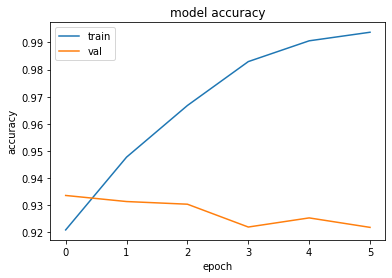

In [18]:
from matplotlib import pyplot as plt

plt.plot(cnnhist.history['accuracy'])
plt.plot(cnnhist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

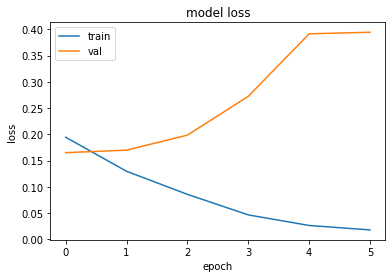

In [19]:
from matplotlib import pyplot as plt

plt.plot(cnnhist.history['loss'])
plt.plot(cnnhist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn import metrics
import plotly.express as px

fpr, tpr, thresholds = metrics.roc_curve(y_test, cnn_preds, pos_label=1)
print(auc(fpr, tpr))
precision, recall, thresholds = precision_recall_curve(y_test, cnn_preds)
print("fpr, tpr is", fpr, tpr)
fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

0.8073942557949028
fpr, tpr is [0.         0.35089431 1.        ] [0.         0.96568282 1.        ]


0.8073942557949028


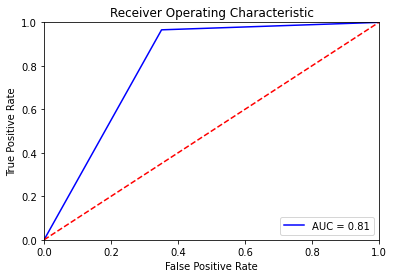

In [23]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc

fpr, tpr, thresholds = metrics.roc_curve(y_test, cnn_preds, pos_label=1)

roc_auc = metrics.auc(fpr, tpr)
print(auc(fpr, tpr))

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
fpr

array([0.        , 0.35089431, 1.        ])